# Recurrent Neural Network - LSTM -  BTC

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Loading the Data

In [31]:
df = pd.read_csv("BTC-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-23,234.052994,236.475006,233.199005,236.462006,236.462006,1.703600e+07
1,2015-04-24,235.970001,236.304993,229.932999,231.268005,231.268005,2.144870e+07
2,2015-04-25,231.235001,232.561005,226.337006,226.389999,226.389999,1.395720e+07
3,2015-04-26,226.410004,226.944000,214.873993,219.429993,219.429993,2.894370e+07
4,2015-04-27,219.429001,233.304993,218.022995,229.285995,229.285995,3.857400e+07
...,...,...,...,...,...,...,...
1823,2020-04-19,7260.922363,7280.521973,7167.054688,7189.424805,7189.424805,3.131121e+10
1824,2020-04-20,7186.873535,7240.290527,6835.502930,6881.958496,6881.958496,3.774711e+10
1825,2020-04-21,6879.784180,6934.551758,6834.442383,6880.323242,6880.323242,3.258974e+10
1826,2020-04-22,6879.440430,7145.865723,6867.781738,7117.207520,7117.207520,3.324915e+10


## Preprocessing Data

In [32]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date").tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [33]:
# Checking the newly formatted DataFrame
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-29,0.005813,0.002898,0.002936,0.000940,0.000940,0.001332
2017-07-30,0.000885,0.000000,0.000000,0.002771,0.002771,0.000000
2017-07-31,0.003202,0.007564,0.004640,0.009810,0.009810,0.002105
2017-08-01,0.009647,0.009395,0.002496,0.000452,0.000452,0.008424
2017-08-02,0.001048,0.000231,0.001454,0.000000,0.000000,0.005296


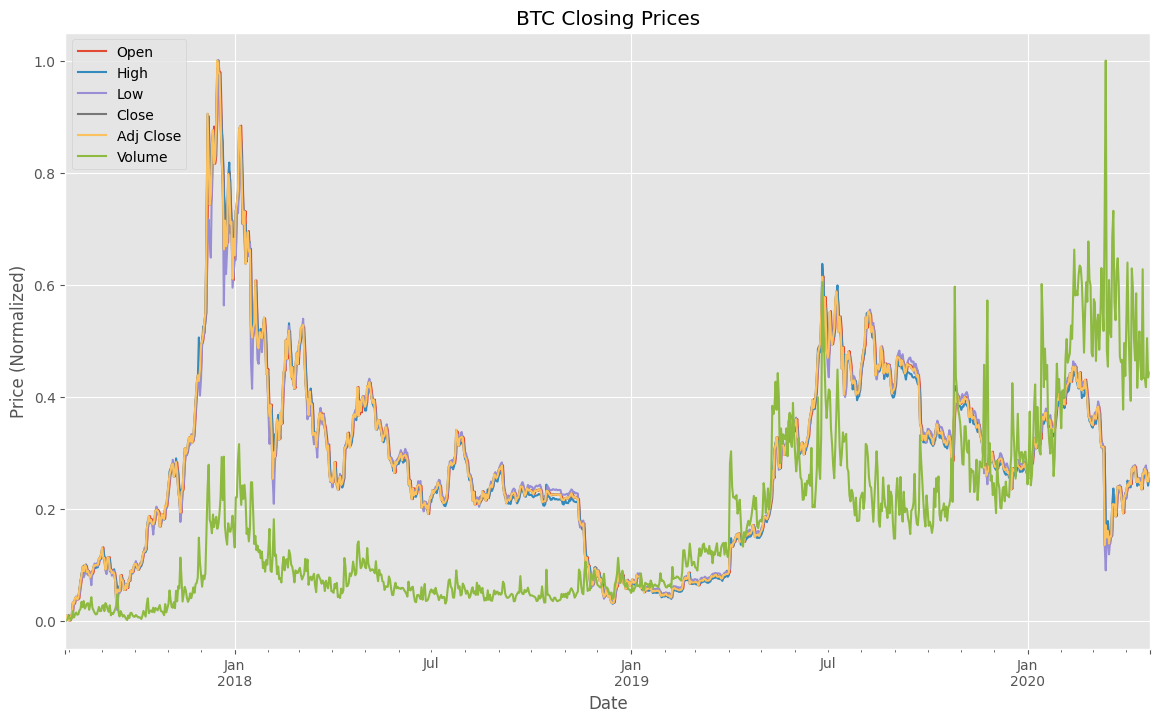

In [22]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

### Functions to prepare the data for LSTM

In [28]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [29]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [30]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

### Splitting the Data

In [38]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))
print("x.shape",X.shape)
print("y.shape",y.shape)


x.shape (961, 30, 1)
y.shape (961, 10)


## Modeling - LSTM (RNN)

### Creating the Neural Network

In [39]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 12)            2064      
                                                                 
 lstm_2 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_3 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_4 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_5 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_6 (LSTM)               (None, 30, 12)            1

In [40]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [41]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Epoch 1/800
27/27 [==============================] - 24s 206ms/step - loss: 0.0865 - accuracy: 0.1042 - val_loss: nan - val_accuracy: 0.0928
Epoch 2/800
27/27 [==============================] - 3s 115ms/step - loss: 0.0450 - accuracy: 0.0764 - val_loss: nan - val_accuracy: 0.0722
Epoch 3/800
27/27 [==============================] - 3s 118ms/step - loss: 0.0329 - accuracy: 0.0671 - val_loss: nan - val_accuracy: 0.0722
Epoch 4/800
27/27 [==============================] - 3s 102ms/step - loss: 0.0233 - accuracy: 0.0671 - val_loss: nan - val_accuracy: 0.0619
Epoch 5/800
27/27 [==============================] - 3s 94ms/step - loss: 0.0168 - accuracy: 0.0822 - val_loss: nan - val_accuracy: 0.0825
Epoch 6/800
27/27 [==============================] - 3s 97ms/step - loss: 0.0154 - accuracy: 0.0984 - val_loss: nan - val_accuracy: 0.0928
Epoch 7/800
27/27 [==============================] - 3s 95ms/step - loss: 0.0143 - accuracy: 0.0972 - val_loss: nan - val_accuracy: 0.1237
Epoch 8/800
27/27 [===

### Plotting the Accuracy and Loss

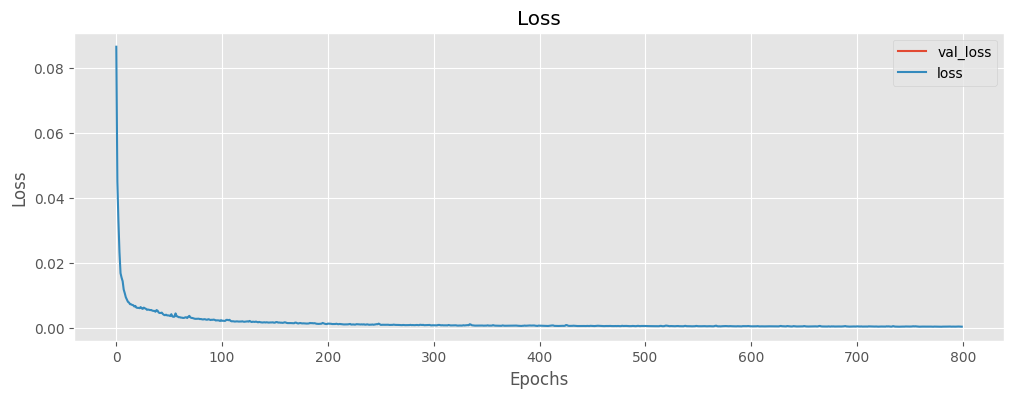

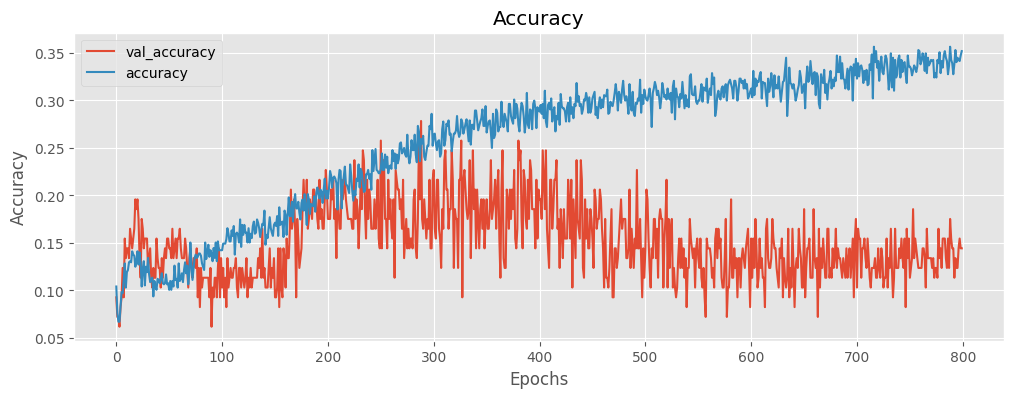

In [42]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

In [45]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

1/1 [==============================] - 0s 76ms/step


ValueError: non-broadcastable output operand with shape (10,1) doesn't match the broadcast shape (10,6)

<Figure size 1200x500 with 0 Axes>

### Predicting/Forecasting the future prices

                  Close
2019-12-02  7750.527979
2019-12-03  7993.556731
2019-12-04  8048.777666
2019-12-05  8293.133372
2019-12-06  8278.055115
2019-12-07  8168.779239
2019-12-08  7833.326193
2019-12-09  7327.463403
2019-12-10  7053.108825
2019-12-11  6831.816325


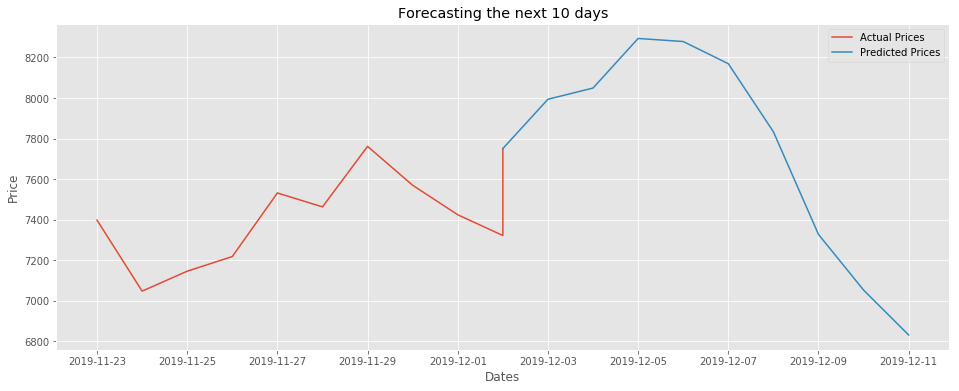

In [94]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()